data: https://ddmal.music.mcgill.ca/research/The_McGill_Billboard_Project_(Chord_Analysis_Dataset)/

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pathlib import Path
import re
from collections import Counter
import pickle
from tqdm import tqdm
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

In [40]:
# CONSTANTS

SAMPLE_EPOCHS = 50
SAMPLE_SIZE = 890
FULL_EPOCHS = 50
BATCH_SIZE = 256

In [41]:
# Set the paths
data_dir = Path('data/McGill-Billboard')
chordino_dir = data_dir / 'chordino'
lab_dir = data_dir / 'lab'
annotations_dir = data_dir / 'annotations'
index_path = index_path = data_dir / 'index.csv'


In [42]:
# Load the dataset index
index_df = pd.read_csv(index_path)
print(f"Total entries in index: {len(index_df)}")
print(f"Entries with complete data: {index_df['title'].notna().sum()}")


Total entries in index: 1300
Entries with complete data: 890


In [43]:
# Drop entries with missing incomplete/unavailable data
index_df = index_df.dropna(subset=['title'])

# Verify new dataframe
print(f'Total Entries after cleaning: {len(index_df)}')

Total Entries after cleaning: 890


In [44]:
index_df.head()

,id,chart_date,target_rank,actual_rank,title,artist,peak_rank,weeks_on_chart
2,3,1961-07-03,56,57.0,I Don't Mind,James Brown,47.0,8.0
3,4,1971-08-07,32,31.0,You've Got A Friend,"Roberta Flack,Donny Hathaway",29.0,12.0
5,6,1980-08-02,15,16.0,The Rose,Bette Midler,3.0,25.0
9,10,1984-03-24,49,51.0,An Innocent Man,Billy Joel,10.0,18.0
11,12,1980-11-15,65,63.0,Lookin' For Love,Johnny Lee,5.0,21.0


In [45]:
# Display basic information
print(f"Number of unique songs: {index_df['title'].nunique()}")
print(f"Number of unique artists: {index_df['artist'].nunique()}")

Number of unique songs: 732
Number of unique artists: 420


In [46]:
# Convert chart_date to datetime
index_df['chart_date'] = pd.to_datetime(index_df['chart_date'])

# Extract year and decade
index_df['year'] = index_df['chart_date'].dt.year
index_df['decade'] = (index_df['year'] // 10) * 10

In [47]:
decade_counts = index_df['decade'].value_counts().sort_index()

print(decade_counts)

decade
1950     27
1960    252
1970    316
1980    252
1990     43
Name: count, dtype: int64


In [48]:
# Check available directories
song_ids = [d.name for d in chordino_dir.iterdir() if d.is_dir()]
print(f"Number of songs with chroma features: {len(song_ids)}")

# Check if the same songs have lab files
lab_ids = [d.name for d in lab_dir.iterdir() if d.is_dir()]
print(f"Number of songs with lab files: {len(lab_ids)}")

# Find songs that have both chroma and labels
common_ids = set(song_ids).intersection(set(lab_ids))
print(f"Number of songs with both features and labels: {len(common_ids)}")

Number of songs with chroma features: 890
Number of songs with lab files: 890
Number of songs with both features and labels: 890


In [49]:
# Explore one example
example_id = list(common_ids)[random.randint(0, len(common_ids))]

# Load chroma features for the example song
chroma_path = chordino_dir / example_id / 'bothchroma.csv'
tuning_path = chordino_dir / example_id / 'tuning.csv'

if chroma_path.exists() and tuning_path.exists():
    chroma_data = pd.read_csv(chroma_path, header=None)
    tuning_data = pd.read_csv(tuning_path, header=None)
    
    print(f"\nChroma shape for song {example_id}: {chroma_data.shape}")
    print(f"Tuning shape for song {example_id}: {tuning_data.shape}")
    
    # Display a sample of the chroma data
    print("\nSample of chroma data:")
    print(chroma_data.head())
else:
    print(f"Chroma or tuning data not found for song {example_id}")

# Load chord labels for the example song
lab_path = lab_dir / example_id / "full.lab"

if lab_path.exists():
    # Read the lab file (tab-separated with no header)
    lab_data = pd.read_csv(lab_path, sep='\t', header=None, names=['start_time', 'end_time', 'chord'])
    
    print(f"\nNumber of chord segments for song {example_id}: {len(lab_data)}")
    print("\nSample of chord labels:")
    print(lab_data.head())
    
    # Count the unique chords in this song
    print(f"\nNumber of unique chords in song {example_id}: {lab_data['chord'].nunique()}")
    print("\nMost common chords:")
    print(lab_data['chord'].value_counts().head(10))
else:
    print(f"Lab file not found for song {example_id}")


Chroma shape for song 0483: (7210, 26)
Tuning shape for song 0483: (1, 5)

Sample of chroma data:
               0        1         2         3         4    5    6         7   \
0  /tmp/audio.wav  0.00000  0.002804  0.571465  0.578757  0.0  0.0  0.000000   
1             NaN  0.04644  0.001885  0.499623  0.559790  0.0  0.0  0.000000   
2             NaN  0.09288  0.001009  0.364933  0.522524  0.0  0.0  0.000000   
3             NaN  0.13932  0.000000  0.338728  0.553561  0.0  0.0  0.000000   
4             NaN  0.18576  0.081719  0.228815  0.465258  0.0  0.0  0.006445   

         8         9   ...        16        17        18        19        20  \
0  0.000000  0.000000  ...  0.648274  1.878240  0.159266  0.243517  0.360494   
1  0.017162  0.000000  ...  0.733824  1.522700  0.108247  0.351397  0.400029   
2  0.097194  0.000000  ...  0.775162  0.893756  0.194734  0.380480  0.530275   
3  0.138891  0.000000  ...  0.768073  0.271229  0.365069  0.321097  0.625120   
4  0.059763  0.01352

Chroma shape for song 0483: (7210, 26)



Sample of chroma data:
               0        1         2         3         4    5    6         7   \
0  /tmp/audio.wav  0.00000  0.002804  0.571465  0.578757  0.0  0.0  0.000000   
1             NaN  0.04644  0.001885  0.499623  0.559790  0.0  0.0  0.000000   
2             NaN  0.09288  0.001009  0.364933  0.522524  0.0  0.0  0.000000   
3             NaN  0.13932  0.000000  0.338728  0.553561  0.0  0.0  0.000000   
4             NaN  0.18576  0.081719  0.228815  0.465258  0.0  0.0  0.006445   

         8         9   ...        16        17        18        19        20  \
0  0.000000  0.000000  ...  0.648274  1.878240  0.159266  0.243517  0.360494   
1  0.017162  0.000000  ...  0.733824  1.522700  0.108247  0.351397  0.400029   
2  0.097194  0.000000  ...  0.775162  0.893756  0.194734  0.380480  0.530275   
3  0.138891  0.000000  ...  0.768073  0.271229  0.365069  0.321097  0.625120   
4  0.059763  0.013522  ...  0.521143  0.945235  0.950790  0.013692  0.539601   

         21  

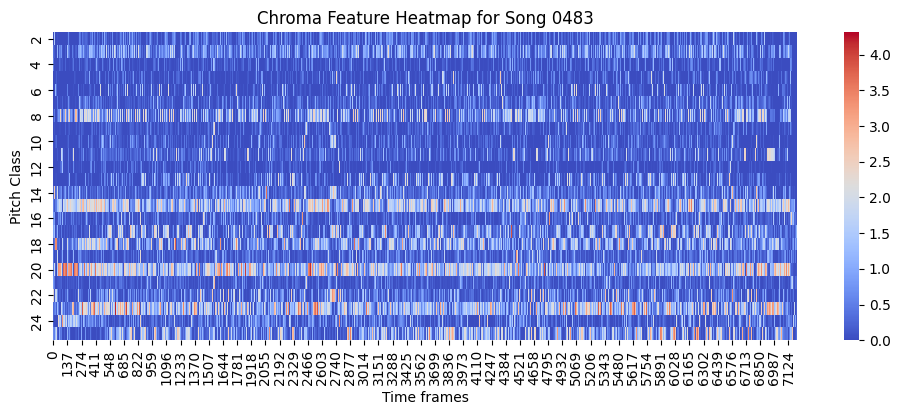

In [50]:
print(f"Chroma shape for song {example_id}: {chroma_data.shape}")
print("\nSample of chroma data:")
print(chroma_data.head())

# Plot chroma data
plt.figure(figsize=(12, 4))
sns.heatmap(chroma_data.iloc[:, 2:].T, cmap='coolwarm', cbar=True)
plt.title(f'Chroma Feature Heatmap for Song {example_id}')
plt.xlabel('Time frames')
plt.ylabel('Pitch Class')
plt.show()

In [51]:
# Load chord labels
lab_data = pd.read_csv(lab_dir / example_id / "full.lab", sep='\t', names=['start', 'end', 'chord'])

print(f"Number of chord segments for song {example_id}: {len(lab_data)}")
print("\nSample of chord segments:")
print(lab_data.head())

Number of chord segments for song 0483: 156

Sample of chord segments:
      start       end chord
0  0.000000  0.029025     N
1  0.029025  0.325079     N
2  0.325079  1.909841     N
3  1.909841  4.068571     N
4  4.068571  4.376961     N


In [52]:
# Count unique chords
unique_chords = lab_data['chord'].nunique()
print(f"Number of unique chords in song {example_id}: {unique_chords}")

Number of unique chords in song 0483: 9


In [53]:
# Most frequent chords
most_common_chords = lab_data['chord'].value_counts().head(10)
print("Most common chords:")
print(most_common_chords)

Most common chords:
chord
Eb:min7    76
Ab:7       41
N          11
Ab:7/b7     6
E:7         6
F:7         5
Ab:7/5      5
Gb:7        4
Bb:maj      2
Name: count, dtype: int64


In [54]:
def load_chroma(song_id):
    """Load chroma features for a given song ID"""
    chroma_path = chordino_dir / song_id / 'bothchroma.csv'
    
    if not chroma_path.exists():
        return None
    
    # Read the file as text first to understand the structure
    with open(chroma_path, 'r') as f:
        first_line = f.readline().strip()
    
    # Check the structure of the file
    columns = first_line.split(',')
    
    # Based on your description, we need to handle two different formats
    if len(columns) >= 14:  # First two columns are non-numeric, followed by 12 chroma values
        # Load the chroma features, skipping the non-numeric metadata columns
        chroma_data = pd.read_csv(chroma_path, header=None, usecols=range(2, 14))
    else:
        # If the format is different, try to determine which columns contain the chroma features
        # For now, we'll just use all columns and convert non-numeric to NaN
        chroma_data = pd.read_csv(chroma_path, header=None)
        # Convert to numeric, coercing errors to NaN
        for col in chroma_data.columns:
            chroma_data[col] = pd.to_numeric(chroma_data[col], errors='coerce')
        # Drop columns with NaN values (these are likely non-numeric metadata columns)
        chroma_data = chroma_data.dropna(axis=1)
    
    # Convert to numpy array, ensuring all values are numeric
    chroma_array = chroma_data.values.astype(np.float32)
    
    # Check for invalid values and replace with zeros
    chroma_array = np.nan_to_num(chroma_array)
    
    return chroma_array

def load_chord_labels(song_id):
    """Load chord labels for a given song ID"""
    lab_path = lab_dir / song_id / "full.lab"
    
    if not lab_path.exists():
        return None
    
    # Load the chord labels
    lab_data = pd.read_csv(lab_path, sep='\t', header=None, names=['start_time', 'end_time', 'chord'])
    
    return lab_data

def get_chroma_timestamps(chroma_array, hop_size=0.01):
    """Generate timestamps for chroma features"""
    # Chordino typically uses a 0.01s hop size (10ms)
    return np.arange(len(chroma_array)) * hop_size

def align_chroma_with_chords(chroma_array, chord_data, chroma_hop_size=0.01):
    """Align chroma features with chord labels"""
    chroma_times = get_chroma_timestamps(chroma_array, chroma_hop_size)
    aligned_chords = []
    
    for i, time in enumerate(chroma_times):
        # Find the chord label for this time point
        chord_idx = ((chord_data['start_time'] <= time) & (chord_data['end_time'] > time)).idxmax()
        if pd.isna(chord_idx):  # No matching chord found
            chord = "N"  # No chord (silence or undefined)
        else:
            chord = chord_data.loc[chord_idx, 'chord']
        
        aligned_chords.append(chord)
    
    return aligned_chords

In [55]:
def build_dataset(song_ids, max_songs=100):
    """Build a dataset of chroma features and chord labels"""
    X = []  # Chroma features
    y = []  # Chord labels
    
    processed_songs = 0
    all_chords = []
    failed_songs = 0
    
    for song_id in tqdm(song_ids):
        if processed_songs >= max_songs:
            break
            
        try:
            # Load chroma and chord data
            chroma_array = load_chroma(song_id)
            chord_data = load_chord_labels(song_id)
            
            if chroma_array is None or chord_data is None:
                continue
                
            # Make sure chroma data is strictly numerical and contains no NaNs or Infs
            if not np.isfinite(chroma_array).all():
                print(f"Warning: Song {song_id} has non-finite values in chroma. Skipping.")
                failed_songs += 1
                continue
                
            # Align chroma with chords
            aligned_chords = align_chroma_with_chords(chroma_array, chord_data)
            
            # Add to dataset
            X.append(chroma_array)
            y.append(aligned_chords)
            
            # Track all unique chords
            all_chords.extend(set(aligned_chords))
            
            processed_songs += 1
        except Exception as e:
            print(f"Error processing song {song_id}: {e}")
            failed_songs += 1
    
    print(f"Successfully processed {processed_songs} songs, failed to process {failed_songs} songs")
    return X, y, list(set(all_chords))

# Let's start with a smaller dataset
sample_size = min(SAMPLE_SIZE, len(common_ids))
song_subset = list(common_ids)[:sample_size]

# Build the initial dataset
X_songs, y_songs, unique_chords = build_dataset(song_subset, max_songs=sample_size)

print(f"Processed {len(X_songs)} songs")
print(f"Number of unique chords: {len(unique_chords)}")
print(f"Some example chords: {unique_chords[:10]}")

100%|██████████| 890/890 [09:30<00:00,  1.56it/s]

Successfully processed 890 songs, failed to process 0 songs
Processed 890 songs
Number of unique chords: 699
Some example chords: ['C:7(#9)', 'Eb:7/3', 'B:sus4', 'F#:sus4', 'Eb:maj/2', 'G:sus4(9)', 'B:min(11)', 'D:min9', 'Eb:sus4(b7)', 'Eb:min7(b13)']


In [56]:
# Flatten the dataset to frame-level
def flatten_dataset(X_songs, y_songs):
    """Convert song-level dataset to frame-level"""
    X_frames = []
    y_frames = []
    
    for i in range(len(X_songs)):
        X_frames.extend(X_songs[i])
        y_frames.extend(y_songs[i])
        
    # Convert to numpy array and ensure correct data type
    X_frames_np = np.array(X_frames, dtype=np.float32)
    y_frames_np = np.array(y_frames)
    
    return X_frames_np, y_frames_np

In [57]:
# Check if we have data to process
if len(X_songs) > 0:
    X_flat, y_flat = flatten_dataset(X_songs, y_songs)

    print(f"Total frames: {len(X_flat)}")
    print(f"Feature shape: {X_flat.shape}")
    
    # Check for any remaining non-finite values
    non_finite_count = np.sum(~np.isfinite(X_flat))
    if non_finite_count > 0:
        print(f"Warning: {non_finite_count} non-finite values found in the flattened data.")
        # Replace non-finite values with zeros
        X_flat = np.nan_to_num(X_flat)
        
    # Make sure the data is normalized (important for neural networks)
    # Chroma features are typically already between 0 and 1, but let's check
    max_value = np.max(X_flat)
    if max_value > 1.0:
        print(f"Max chroma value is {max_value}, normalizing to [0, 1] range")
        X_flat = X_flat / max_value

    # Encode the chord labels
    label_encoder = LabelEncoder()
    try:
        y_encoded = label_encoder.fit_transform(y_flat)
        
        # Save the label encoder for later use
        os.makedirs('models', exist_ok=True)
        with open('models/chord_label_encoder.pkl', 'wb') as f:
            pickle.dump(label_encoder, f)
        
        # Get the number of classes
        n_classes = len(label_encoder.classes_)
        print(f"Number of chord classes: {n_classes}")
        
        # Convert to one-hot encoding
        y_onehot = to_categorical(y_encoded, num_classes=n_classes)
        
        # Split into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_flat, y_onehot, test_size=0.2, random_state=42)
        
        print(f"Training set: {X_train.shape}")
        print(f"Testing set: {X_test.shape}")
    except Exception as e:
        print(f"Error in encoding labels: {e}")
        print("This may be due to empty or invalid chord labels.")
else:
    print("No data to process. Check the dataset loading steps above for errors.")

Total frames: 4143772
Feature shape: (4143772, 12)
Max chroma value is 3.390820026397705, normalizing to [0, 1] range
Number of chord classes: 699
Error in encoding labels: Unable to allocate 17.3 GiB for an array with shape (3315017, 699) and data type float64
This may be due to empty or invalid chord labels.


Top 20 chords:
A:maj: 34977
G:maj: 25720
C:maj: 24605
N: 24048
D:maj: 20966
E:maj: 20199
Bb:maj: 15427
F:maj: 14893
E:min: 12902
A:min: 12892
D:min: 9792
B:maj: 9473
C:min: 8383
D:7: 7650
F:7: 7470
A:7: 7390
Ab:7(#9): 7146
F:min: 5924
G:7: 5571
C:7: 4898


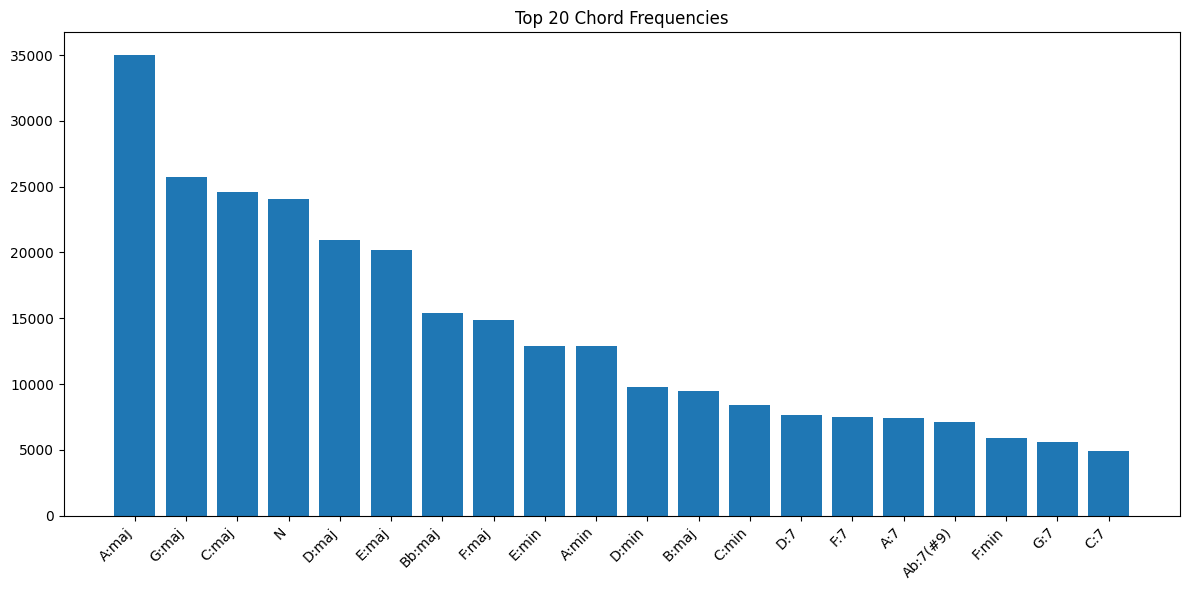

In [ ]:
# Count chord occurrences
chord_counts = Counter(y_flat)

# Get the top 20 chords
top_chords = chord_counts.most_common(20)
print("Top 20 chords:")
for chord, count in top_chords:
    print(f"{chord}: {count}")

# Visualize chord distribution
plt.figure(figsize=(12, 6))
counts = [count for _, count in top_chords]
labels = [chord for chord, _ in top_chords]

plt.bar(range(len(counts)), counts)
plt.xticks(range(len(counts)), labels, rotation=45, ha='right')
plt.title('Top 20 Chord Frequencies')
plt.tight_layout()
plt.show()

In [ ]:
# Build and Train Models

def create_feedforward_model(input_shape, n_classes):
    """Create a simple feedforward neural network optimized for chroma input"""
    model = Sequential([
        # Input layer - shape is (12,) for chroma vectors
        Dense(128, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        
        # Hidden layers
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Output layer
        Dense(n_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_cnn_model(input_shape, n_classes):
    """Create a 1D CNN model for chroma processing"""
    # For chroma vectors, we reshape to (12, 1) to apply 1D convolutions
    model = Sequential([
        # Input layer
        Input(shape=input_shape),
        
        # Reshape to have a time dimension (treating the 12 chroma bins as a sequence)
        tf.keras.layers.Reshape((input_shape[0], 1)),
        
        # First conv block
        Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # Second conv block
        Conv1D(128, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # Flatten and dense layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Output layer
        Dense(n_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_lstm_model(input_shape, n_classes):
    """Create an LSTM model for chroma sequences"""
    # Reshape chroma vectors to sequences
    model = Sequential([
        # Input layer
        Input(shape=input_shape),
        
        # Reshape to have a time dimension
        tf.keras.layers.Reshape((input_shape[0], 1)),
        
        # LSTM layers
        LSTM(128, return_sequences=True),
        BatchNormalization(),
        Dropout(0.4),
        
        LSTM(64),
        BatchNormalization(),
        Dropout(0.3),
        
        # Dense layers
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Output layer
        Dense(n_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Get input shape from training data
input_shape = (X_train.shape[1],)
print(f"Input shape for models: {input_shape}")

# Define callbacks for training
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    ModelCheckpoint('models/best_model_checkpoint.keras', save_best_only=True, verbose=0)
]

# Train the feedforward model

ff_model = create_feedforward_model(input_shape, n_classes)
print(ff_model.summary())

Input shape for models: (12,)

--- Training Feedforward Model ---


c:\Users\RohanGupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 209)            │        26,961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,409 (638.32 KB)

 Trainable params: 161,873 (632.32 KB)

 Non-trainable params: 1,536 (6.00 KB)

None


In [ ]:
history_ff = ff_model.fit(
    X_train, y_train,
    epochs=SAMPLE_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
2298/2306 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1035 - loss: 4.3196
Epoch 1: val_loss improved from inf to 3.69313, saving model to models/best_model_checkpoint.keras
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.1036 - loss: 4.3184 - val_accuracy: 0.1417 - val_loss: 3.6931 - learning_rate: 0.0010
Epoch 2/30
2297/2306 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1331 - loss: 3.7764
Epoch 2: val_loss improved from 3.69313 to 3.62460, saving model to models/best_model_checkpoint.keras
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1331 - loss: 3.7764 - val_accuracy: 0.1483 - val_loss: 3.6246 - learning_rate: 0.0010
Epoch 3/30
2298/2306 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1389 - loss: 3.7236
Epoch 3: val_loss improved from 3.62460 to 3.58225, saving model to models/best_model_checkpoint.keras
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1389 - loss: 3.7236 - val_accuracy: 0.1541 - val_loss: 3.5822 - learning_rate: 0.0010

In [ ]:
# Save the model
ff_model.save('models/chord_classifier_feedforward.keras')
print("Feedforward model saved successfully")

Feedforward model saved successfully


In [ ]:
# Train the CNN model

cnn_model = create_cnn_model(input_shape, n_classes)
print(cnn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 12, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 12, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 209)            │        26,961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,681 (725.32 KB)

 Trainable params: 184,529 (720.82 KB)

 Non-trainable params: 1,152 (4.50 KB)

None
Epoch 1/30
2300/2306 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1009 - loss: 4.3374
Epoch 1: val_loss did not improve from 3.39015
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.1009 - loss: 4.3364 - val_accuracy: 0.1497 - val_loss: 3.6669 - learning_rate: 0.0010
Epoch 2/30
2301/2306 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1384 - loss: 3.7480
Epoch 2: val_loss did not improve from 3.39015
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.1384 - loss: 3.7479 - val_accuracy: 0.1548 - val_loss: 3.5888 - learning_rate: 0.0010
Epoch 3/30
2302/2306 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1433 - loss: 3.6864
Epoch 3: val_loss did not improve from 3.39015
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.1433 - loss: 3.6864 - val_accuracy: 0.1609 - val_loss: 3.5341 - learning_rate: 0.0010
Epoch 4/30
2299/2306 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1463 - loss: 3.6501
Epoch 4: val_loss did not improve from 3.39015
2306/2306 ━━━━━━━━━━━━━

In [ ]:
history_cnn = cnn_model.fit(
    X_train, y_train,
    epochs=SAMPLE_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
# Save the model
cnn_model.save('models/chord_classifier_cnn.keras')
print("CNN model saved successfully")

CNN model saved successfully


In [ ]:
# Train the LSTM model

lstm_model = create_lstm_model(input_shape, n_classes)
print(lstm_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 12, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 12, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 209)            │        26,961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,529 (595.82 KB)

 Trainable params: 151,889 (593.32 KB)

 Non-trainable params: 640 (2.50 KB)

None
Epoch 1/30
2305/2306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0717 - loss: 4.5426
Epoch 1: val_loss did not improve from 3.31831
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - accuracy: 0.0717 - loss: 4.5423 - val_accuracy: 0.1130 - val_loss: 3.9767 - learning_rate: 0.0010
Epoch 2/30
2304/2306 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1210 - loss: 3.9035
Epoch 2: val_loss did not improve from 3.31831
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 50s 22ms/step - accuracy: 0.1210 - loss: 3.9034 - val_accuracy: 0.1429 - val_loss: 3.6923 - learning_rate: 0.0010
Epoch 3/30
2305/2306 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1359 - loss: 3.7504
Epoch 3: val_loss did not improve from 3.31831
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 49s 21ms/step - accuracy: 0.1360 - loss: 3.7504 - val_accuracy: 0.1497 - val_loss: 3.6286 - learning_rate: 0.0010
Epoch 4/30
2305/2306 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1427 - loss: 3.6909
Epoch 4: val_loss did not improve from 3.31831
2306/2306 ━━━━━━

In [ ]:
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=SAMPLE_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
# Save the model
lstm_model.save('models/chord_classifier_lstm.keras')
print("LSTM model saved successfully")

LSTM model saved successfully


In [ ]:
   # Function to safely evaluate models
def safe_evaluate(model, model_name):
    try:
        scores = model.evaluate(X_test, y_test, verbose=1)
        print(f"{model_name} - Test Loss: {scores[0]:.4f}, Test Accuracy: {scores[1]:.4f}")
        return scores
    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")
        return None

# Evaluate each model if it exists
if 'ff_model' in locals():
    ff_scores = safe_evaluate(ff_model, "Feedforward Model")

if 'cnn_model' in locals():
    cnn_scores = safe_evaluate(cnn_model, "CNN Model")

if 'lstm_model' in locals():
    lstm_scores = safe_evaluate(lstm_model, "LSTM Model")


--- Model Evaluation ---
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.1786 - loss: 3.3831
Feedforward Model - Test Loss: 3.3861, Test Accuracy: 0.1775
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1899 - loss: 3.3081
CNN Model - Test Loss: 3.3134, Test Accuracy: 0.1887
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.1789 - loss: 3.3834
LSTM Model - Test Loss: 3.3885, Test Accuracy: 0.1792


In [ ]:
# Plot training history
def plot_history(history, title):
    if history is None:
        print(f"No training history available for {title}")
        return
        
    try:
        plt.figure(figsize=(12, 4))
        
        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'{title} - Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower right')
        
        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'{title} - Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        
        plt.tight_layout()
        plt.savefig(f"models/{title.replace(' ', '_').lower()}_training_history.png")
        plt.show()
    except Exception as e:
        print(f"Error plotting history for {title}: {e}")

In [ ]:
def print_history_results(history, title):
    if history is None:
        print(f"No training history available for {title}")
        return
        
    try:
        print(f"\n=== {title} Training Results ===")
        
        # Extract final epoch metrics
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        # Calculate best validation metrics
        max_val_acc = max(history.history['val_accuracy'])
        min_val_loss = min(history.history['val_loss'])
        best_epoch_acc = history.history['val_accuracy'].index(max_val_acc) + 1
        best_epoch_loss = history.history['val_loss'].index(min_val_loss) + 1
        
        # Print formatted results
        print(f"{'Final Training Accuracy:':<25} {train_acc:.4f}")
        print(f"{'Final Validation Accuracy:':<25} {val_acc:.4f}")
        print(f"{'Final Training Loss:':<25} {train_loss:.4f}")
        print(f"{'Final Validation Loss:':<25} {val_loss:.4f}")
        print("\nBest Validation Metrics:")
        print(f"{'Max Validation Accuracy:':<25} {max_val_acc:.4f} (epoch {best_epoch_acc})")
        print(f"{'Min Validation Loss:':<25} {min_val_loss:.4f} (epoch {best_epoch_loss})")
        
    except KeyError as e:
        print(f"Missing key in history data: {e}")
    except Exception as e:
        print(f"Error processing results for {title}: {e}")

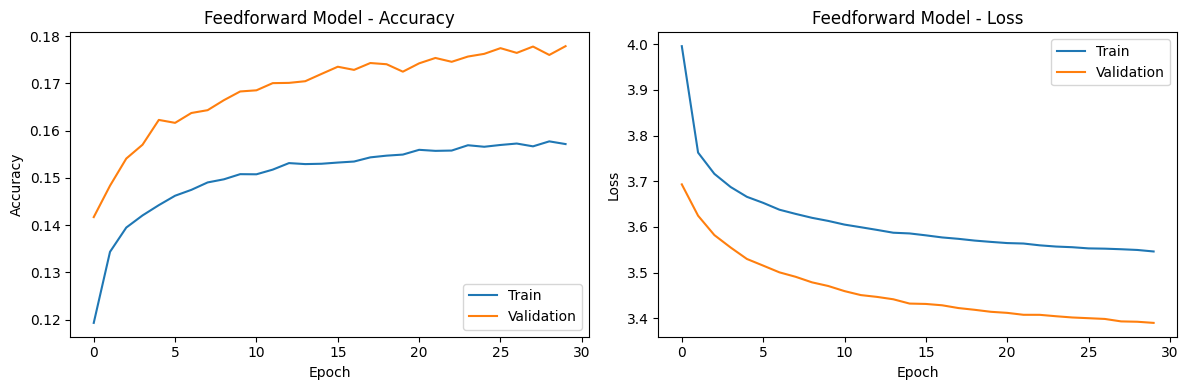


=== Feedforward Model Training Results ===
Final Training Accuracy:  0.1572
Final Validation Accuracy: 0.1779
Final Training Loss:      3.5463
Final Validation Loss:    3.3901

Best Validation Metrics:
Max Validation Accuracy:  0.1779 (epoch 30)
Min Validation Loss:      3.3901 (epoch 30)


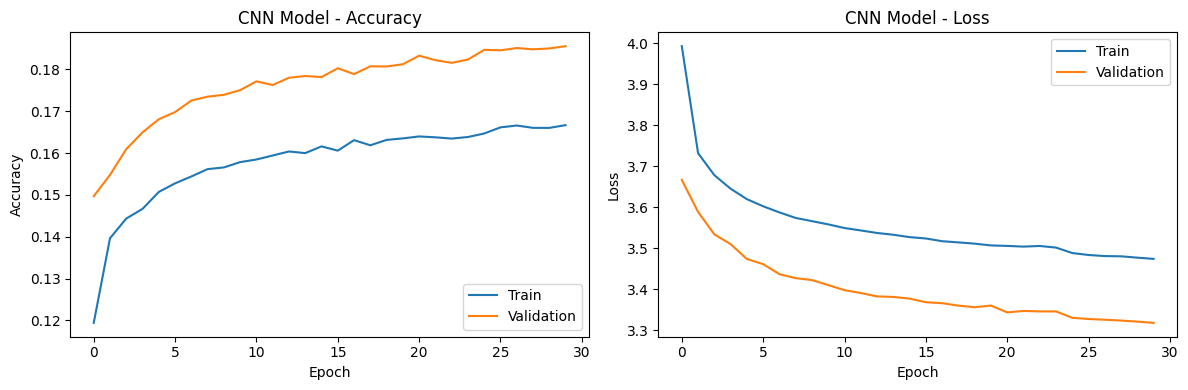


=== CNN Model Training Results ===
Final Training Accuracy:  0.1667
Final Validation Accuracy: 0.1855
Final Training Loss:      3.4743
Final Validation Loss:    3.3183

Best Validation Metrics:
Max Validation Accuracy:  0.1855 (epoch 30)
Min Validation Loss:      3.3183 (epoch 30)


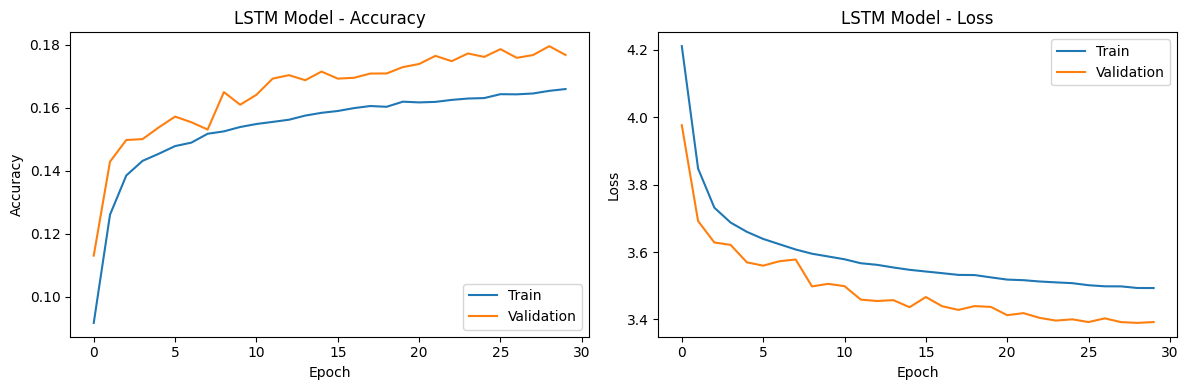


=== LSTM Model Training Results ===
Final Training Accuracy:  0.1659
Final Validation Accuracy: 0.1767
Final Training Loss:      3.4933
Final Validation Loss:    3.3923

Best Validation Metrics:
Max Validation Accuracy:  0.1795 (epoch 29)
Min Validation Loss:      3.3899 (epoch 29)


In [ ]:
# Plot histories if available
if 'history_ff' in locals():
    plot_history(history_ff, 'Feedforward Model')
    print_history_results(history_ff, 'Feedforward Model')

if 'history_cnn' in locals():
    plot_history(history_cnn, 'CNN Model')
    print_history_results(history_cnn, 'CNN Model')

if 'history_lstm' in locals():
    plot_history(history_lstm, 'LSTM Model')
    print_history_results(history_lstm, 'LSTM Model')

In [ ]:
# Function to get confusion matrix and classification report
def model_analysis(model, X, y, label_encoder, title):
    """Analyze model performance with confusion matrix and classification report"""
    # Get predictions
    y_pred_proba = model.predict(X)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y, axis=1)
    
    # Get class names
    class_names = label_encoder.classes_
    
    # Classification report
    print(f"\n{title} - Classification Report:")
    print(classification_report(
        y_true, 
        y_pred, 
        target_names=class_names,
        labels=range(len(class_names)),
        zero_division=0
    ))

In [ ]:
# Analyze the best performing model
best_model = cnn_model
model_analysis(best_model, X_test, y_test, label_encoder, 'Best Model')

2882/2882 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

Best Model - Classification Report:
                 precision    recall  f1-score   support

           A:11       0.18      0.06      0.09       448
            A:5       0.00      0.00      0.00       194
          A:5/4       0.50      0.02      0.04        49
            A:7       0.34      0.14      0.19      1508
          A:9/5       0.00      0.00      0.00        20
          A:maj       0.19      0.54      0.29      6977
       A:maj(9)       0.29      0.02      0.04       105
        A:maj/3       0.00      0.00      0.00        70
        A:maj/5       0.00      0.00      0.00       298
         A:maj6       0.00      0.00      0.00       218
         A:maj7       0.00      0.00      0.00        29
          A:min       0.25      0.24      0.25      2572
       A:min/b3       0.00      0.00      0.00        15
         A:min7       0.15      0.00      0.01       732
         A:min9       0.00      0.00      0.00       115
    A:m